<a href="https://colab.research.google.com/github/musicjae/Hands_on_ML/blob/master/(2)ML_project_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving cal_housing.domain to cal_housing.domain
User uploaded file "cal_housing.domain" with length 237 bytes


#2.2 큰 그림 보기  
  
캘리포니아 인구조사 데이터 이용하여, 캘리포니아 주택 가격 모델 만들기

### 문제 정의  
  
파이프라인: 데이터 처리 component들이 연속되어 있는 것. 
  
> 각 컴포넌트는 독립적.이들 간의 인터페이스는 데이터 저장소 뿐.  
  
우리가 풀 문제는 (1) 예측을 위한 회귀를 사용하니까 지도 학습, (2) 여러 특성을 사용하니까 Multiple Regression, (3) 하나의 값만 예측하니까 Univariate Regression 문제이다.

### 성능 측정 지표 선택  
  
- RMSE 평균 제곱근 오차

In [5]:
import numpy as np


def predicted_fn(h):

    return 2*h+3


x = [1,2,3]
y=[-100,-200,-300]



for i in range(len(x)):

    z=np.mean((predicted_fn(x[i])-y[i])**2)
    print(i,'th RMSE: ',z)

0 th RMSE:  11025.0
1 th RMSE:  42849.0
2 th RMSE:  95481.0


- MAE 평균 절댓값 오차  
  
이상치로 보이는 경우가 많을 때는 이 MAE도 고려해볼 수 있다.

# 2.3 데이터 로드  


In [72]:
import pandas as pd

cal_housing_data = pd.read_csv('cal_housing.data')
cal_housing_data.shape

(20639, 9)

In [73]:
cal_housing_data.head()

,-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000
0,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
1,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
2,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
3,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
4,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0


In [74]:
cal_housing_data.rename(columns={'-122.230000':'longitude',
                                 '37.880000':'latitude',
                                 '41.000000':'housing_median_age',
                                 '880.000000':'total_rooms',
                                 '129.000000':'total_bedrooms',
                                 '322.000000':'population',
                                 '126.000000':'households',
                                 '8.325200':'median_income',
                                 '452600.000000':'median_house_value'},inplace=True)
#,'housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value','ocean_proximity'


In [76]:
cal_housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
1,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
2,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
3,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
4,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0


In [77]:
cal_housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20639 entries, 0 to 20638
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20639 non-null  float64
 1   latitude            20639 non-null  float64
 2   housing_median_age  20639 non-null  float64
 3   total_rooms         20639 non-null  float64
 4   total_bedrooms      20639 non-null  float64
 5   population          20639 non-null  float64
 6   households          20639 non-null  float64
 7   median_income       20639 non-null  float64
 8   median_house_value  20639 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [82]:
cal_housing_domain = pd.read_csv('cal_housing.domain')
cal_housing_domain.shape

(8, 1)

In [83]:
cal_housing_data.describe() # 숫자형 특성의 요약정보

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000
mean,-119.569576,35.631753,28.638888,2635.848152,537.917825,1425.530210,499.557779,3.870455,206843.910122
std,2.003495,2.135947,12.585568,2181.633870,421.248495,1132.463507,382.330173,1.899615,115385.731702
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1448.000000,295.500000,787.000000,280.000000,2.563100,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534700,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.742850,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


히스토그램 그리기

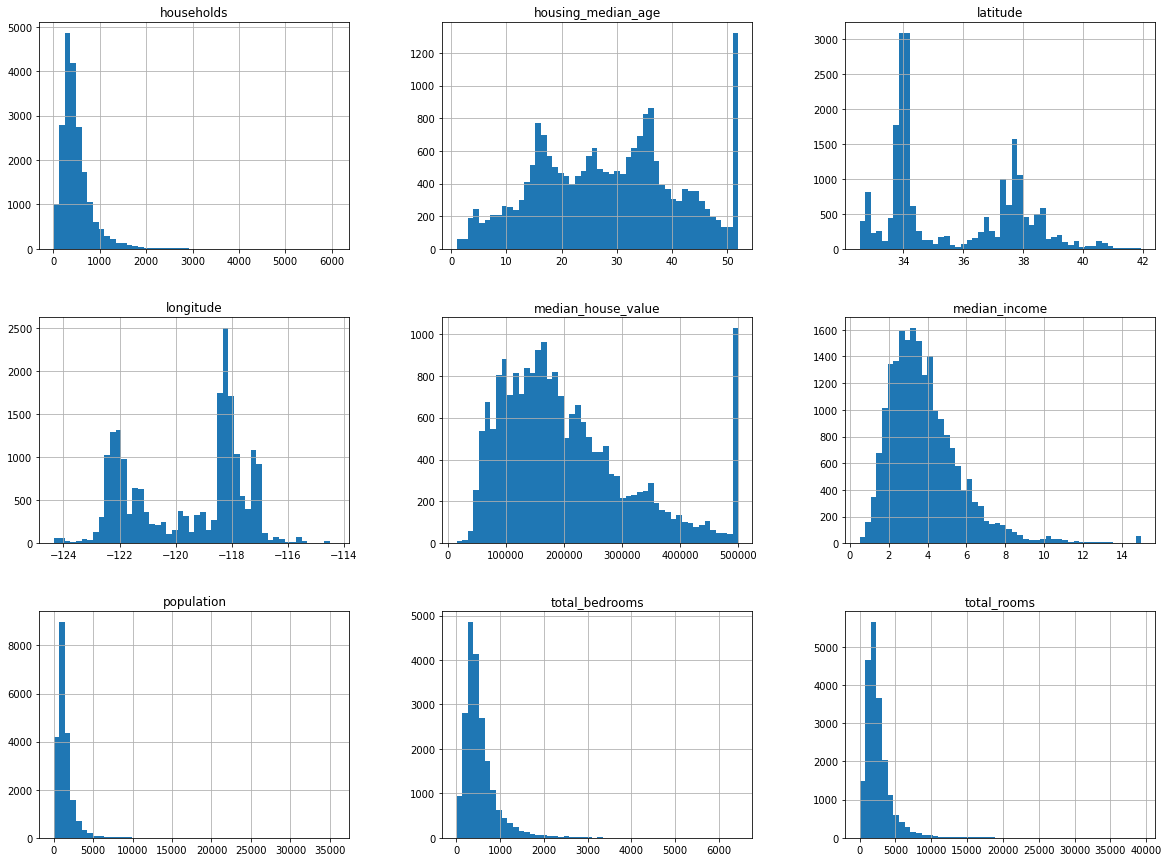

In [84]:
%matplotlib inline
# 맷플롯립이 코랩 자체의 백엔드 사용하게 설정해줘
import matplotlib.pyplot as plt

cal_housing_data.hist(bins=50,figsize=(20,15))
plt.show()

데이터 셋 만들기  
  
- Data Snooping Bias: 테스트 셋을 들여다 보면 여기서 겉으로 드러난 어떤 패턴에 속아 특정 ML 모델을 선택하게 될지 모른다. 이걸로 일반화 오차를 추정 시, 너무 낙관적인 추정이 되어, 막상 시스템 론칭 시에 기대한 성능이 안 나올 수 있다.

### 순수히 무작위적인 샘플링 방식

In [85]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(cal_housing_data, test_size = 0.2, random_state = 42)

In [86]:
print(train_set.shape, test_set.shape)
print(train_set[:3])

(16511, 9) (4128, 9)
       longitude  latitude  ...  median_income  median_house_value
14195    -117.03     32.71  ...         3.2596            103000.0
8267     -118.17     33.74  ...         3.7838            500001.0
17444    -120.48     34.66  ...         4.1563            172600.0

[3 rows x 9 columns]


위 방식은 데이터셋이 충분히 **클** 때에는 일반적으로 괜찮지만, 그렇지 않은 경우에 **샘플링** **편향**이 생길 가능성이 높다. (가령, 설문조사 때 전화할 샘플 대상들을 연구자들은 무작위로 선정하지 않는다.)  
  
가령, 미국 인구 51.3 %가 여성이고, 48.7 % 가 남성이면, 잘 구성된 설문조사는 **샘플에서도** 이 비율을 **유지해야** 합니다. ===> **계층적** **샘플링** Stratified Sampling  
  
전체 인구는 계층strata는 동질의 그룹으로 나뉘고 테스트셋이 전체 인구를 **대표할** **수** **있도록** 각 계층에서 올바른 수의 샘플을 추출한다. (==> 편향이 위 방법 보다 적다)

### 계층적 샘플링

In [91]:
cal_housing_data["income_cat"] = pd.cut(cal_housing_data["median_income"],
                                        bins = [0,2,4,6,8, np.inf],
                                        labels = [1,2,3,4,5])

In [92]:
print(cal_housing_data["income_cat"])

0        5
1        4
2        3
3        2
4        3
        ..
20634    1
20635    2
20636    1
20637    1
20638    2
Name: income_cat, Length: 20639, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


AxesSubplot(0.125,0.125;0.775x0.755)


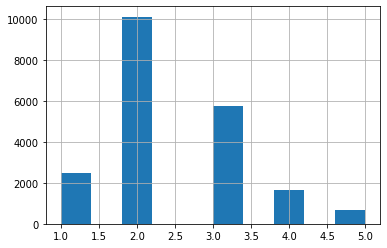

In [93]:
print(cal_housing_data["income_cat"].hist())

### 위에서 구한 소득 카테고리를 기반으로 계층 샘플링 하기

In [94]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits = 1,
    test_size = 0.2,
    random_state = 42
)

for train_index, test_index in split.split(cal_housing_data, cal_housing_data["income_cat"]):

    strat_train_set = cal_housing_data.loc[train_index]
    strat_test_set = cal_housing_data.loc[test_index]

테스트 셋에서 소득 카테고리의 비율

In [95]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

2    0.489099
3    0.277374
1    0.119186
4    0.080911
5    0.033430
Name: income_cat, dtype: float64

In [96]:
for set_ in (strat_train_set, strat_test_set):

    set_.drop("income_cat", axis=1, inplace= True) # drop 메서드는 "행/열 삭제해" axis=0 -> 행 삭제, 1 -> 열 삭제. 

# 2.4 데이터 이해를 위한 탐색/시각화

In [97]:
cal_housing_data = strat_train_set.copy()

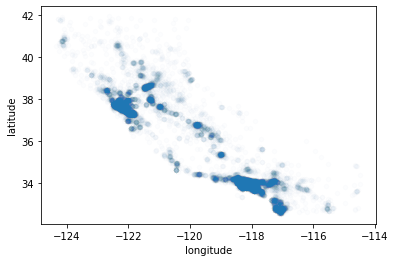

In [101]:
cal_housing_data.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.01) # alpha는 데이터가 밀집된 지역을 잘 보여준다.

### 주택 가격 나타내기

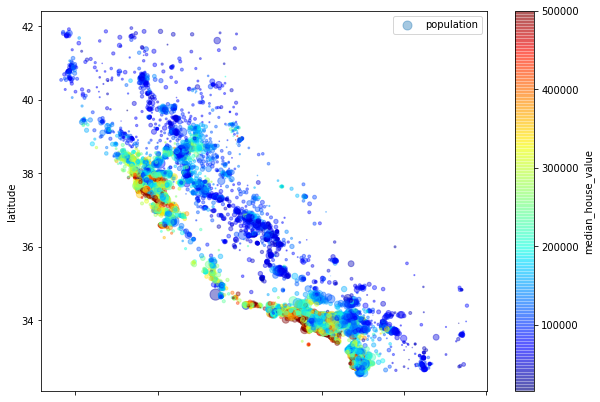

In [104]:
cal_housing_data.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.4,
                      s=cal_housing_data["population"]/100, label = "population", figsize=(10,7),
                      c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True,
                      )
plt.legend()

### 상관관계 조사  
  
모든 특성 간의 표준 상관계수 standard correlation coefficient (피어슨의 r)을 corr() 메서드를 이용해 쉽게 계산할 수 있다. 
  



In [105]:
corr_matrix = cal_housing_data.corr()

In [106]:
corr_matrix["median_house_value"] # range: -1,1

longitude            -0.044821
latitude             -0.144405
housing_median_age    0.110720
total_rooms           0.131413
total_bedrooms        0.046493
population           -0.029207
households            0.062300
median_income         0.688794
median_house_value    1.000000
Name: median_house_value, dtype: float64

위 카테고리 간의 상관 계수를 보면, 중간 주택 가격과 중간 수입 간의 상대적으로 강한 상관 관계를 볼 수 있다. 이는 주간 수입이 증가하면 중간 주택 가격이 증가한다는 것을 함의한다. 반면에, 계수가 0에 가까우면 선형적 상관 관계가 없음을 의미한다.

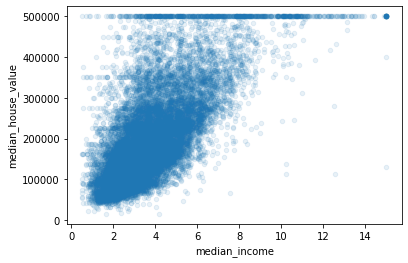

In [107]:
cal_housing_data.plot(kind="scatter",
                      x="median_income",
                      y="median_house_value",
                      alpha=0.1)


위 그래프를 통해 우리는 (1) 양 카테고리 간의 상관 관계가  강하다는 것을 알 수 있고 -- 위쪽으로 향함, 포인트들이 서로 가까워 --, (2) 가격 제한값이 50만 달러라는 것을 알 수 있다.

### 새로운 특성 만들기  
  


In [108]:
cal_housing_data["bedrooms_per_room"] = cal_housing_data["total_bedrooms"]/cal_housing_data["total_rooms"]

다시 상관 관계 조사

In [109]:
corr_matrix = cal_housing_data.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688794
total_rooms           0.131413
housing_median_age    0.110720
households            0.062300
total_bedrooms        0.046493
population           -0.029207
longitude            -0.044821
latitude             -0.144405
bedrooms_per_room    -0.257939
Name: median_house_value, dtype: float64

위 데이터 분석을 통해 우리는 -- bedrooms_per_room의 값이 0에서 더 멀기 때문에 -- 총 방의 개수, 침실의 개수 보다 중간 가격과 더 높은 상관 관계를 가진다는 것을 알 수 있다. 그러면 이 새롭게 만들어진 특성은 우리가 주택 가격 예측을 함에 있어서 유의미한 특성이라고 간주될 수 있다.